In [ ]:
# %pip install torch torchvision torchsummary numpy matplotlib

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
print(device)

cuda


In [3]:
# Updated transforms with normalization for pre-trained models
# Using ImageNet normalization values
transform_train = transforms.Compose([
    transforms.Resize(224),  # MobileNetV2 expects 224x224 input
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [4]:
print('Number of images in the training dataset:', len(train_set))
print('Number of images in the testing dataset:', len(test_set))

Number of images in the training dataset: 50000
Number of images in the testing dataset: 10000


In [5]:
print(f"Shape of the images in the training dataset: {train_loader.dataset[0][0].shape}")

Shape of the images in the training dataset: torch.Size([3, 224, 224])


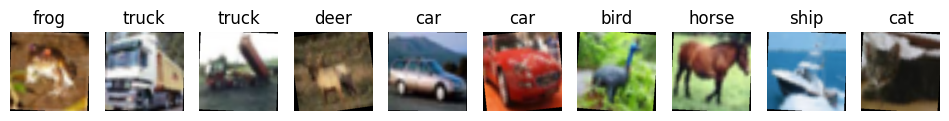

In [6]:
# Visualization function with denormalization for ImageNet stats
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for i in range(10):
    image = train_loader.dataset[i][0]
    denormalized_image = denormalize(image).permute(1, 2, 0).numpy()
    denormalized_image = np.clip(denormalized_image, 0, 1)
    axes[i].imshow(denormalized_image)
    axes[i].set_title(classes[train_loader.dataset[i][1]])
    axes[i].axis('off')
plt.show()

In [7]:
# Transfer Learning Model with Selective Fine-tuning
class MobileNetV2Transfer(nn.Module):
    def __init__(self, num_classes=10, freeze_layers=True):
        super(MobileNetV2Transfer, self).__init__()
        
        # Load pre-trained MobileNetV2
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        
        # Freeze early layers for selective fine-tuning
        if freeze_layers:
            # Freeze all layers except the last few
            for param in self.mobilenet.features[:-3].parameters():
                param.requires_grad = False
        
        # Replace the classifier
        num_features = self.mobilenet.classifier[1].in_features
        self.mobilenet.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.mobilenet(x)
        return F.log_softmax(x, dim=1)

# Initialize model
net = MobileNetV2Transfer(num_classes=10, freeze_layers=True)
net = net.to(device)

# Print trainable parameters
trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in net.parameters())
print(f"Trainable parameters: {trainable_params:,} / {total_params:,}")
print(f"Percentage trainable: {100 * trainable_params / total_params:.2f}%")

/home/fhs/miniconda3/envs/nn-env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/fhs/miniconda3/envs/nn-env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /home/fhs/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:07<00:00, 1.93MB/s]


Trainable parameters: 1,867,082 / 2,884,874
Percentage trainable: 64.72%


In [8]:
# Model summary
summary(net, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [10]:
# Training with learning rate scheduling
loss_function = nn.NLLLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

epochs = 15
train_losses = []
best_accuracy = 0

for epoch in range(epochs):
    net.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = loss_function(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if i % 500 == 499:
            avg_loss = running_loss / 500
            train_losses.append(avg_loss)
            print(f'[{epoch + 1}/{epochs}, {i + 1:5d}] loss: {avg_loss:.3f}')
            running_loss = 0.0
    
    # Calculate training accuracy
    train_accuracy = 100 * correct / total
    print(f'Epoch {epoch + 1} Training Accuracy: {train_accuracy:.2f}%')
    
    # Validation
    net.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_accuracy = 100 * val_correct / val_total
    avg_val_loss = val_loss / len(test_loader)
    print(f'Epoch {epoch + 1} Validation Accuracy: {val_accuracy:.2f}%, Loss: {avg_val_loss:.3f}')
    
    # Learning rate scheduling
    scheduler.step(avg_val_loss)

    current_lr = optimizer.param_groups[0]['lr']
    print(f'Current learning rate: {current_lr}')
    
    # Save best model
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(net.state_dict(), 'best_model.pth')
        print(f'Best model saved with accuracy: {best_accuracy:.2f}%')
    
    print('-' * 60)

print('Finished Training')
print(f'Best Validation Accuracy: {best_accuracy:.2f}%')

[1/15,   500] loss: 0.856
[1/15,  1000] loss: 0.638
[1/15,  1500] loss: 0.588
Epoch 1 Training Accuracy: 76.72%
Epoch 1 Validation Accuracy: 82.22%, Loss: 0.520
Current learning rate: 0.001
Best model saved with accuracy: 82.22%
------------------------------------------------------------
[2/15,   500] loss: 0.522
[2/15,  1000] loss: 0.510
[2/15,  1500] loss: 0.488
Epoch 2 Training Accuracy: 83.07%
Epoch 2 Validation Accuracy: 85.83%, Loss: 0.430
Current learning rate: 0.001
Best model saved with accuracy: 85.83%
------------------------------------------------------------
[3/15,   500] loss: 0.456
[3/15,  1000] loss: 0.445
[3/15,  1500] loss: 0.440
Epoch 3 Training Accuracy: 84.99%
Epoch 3 Validation Accuracy: 87.20%, Loss: 0.384
Current learning rate: 0.001
Best model saved with accuracy: 87.20%
------------------------------------------------------------
[4/15,   500] loss: 0.414
[4/15,  1000] loss: 0.415
[4/15,  1500] loss: 0.412
Epoch 4 Training Accuracy: 86.16%
Epoch 4 Validation

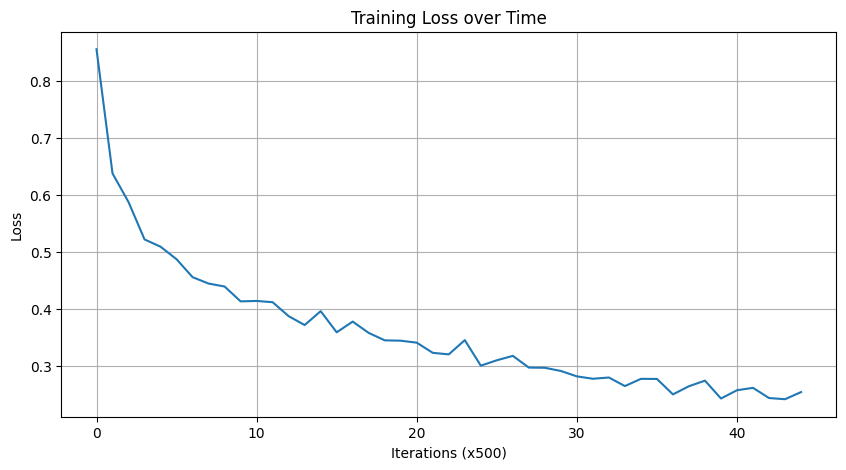

In [11]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.xlabel('Iterations (x500)')
plt.ylabel('Loss')
plt.title('Training Loss over Time')
plt.grid(True)
plt.show()

In [12]:
def view_classification(image, probabilities):
    probabilities = probabilities.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)

    # Denormalize for visualization
    denormalized_image = denormalize(image).permute(1, 2, 0).numpy()
    denormalized_image = np.clip(denormalized_image, 0, 1)
    ax1.imshow(denormalized_image)
    ax1.axis('off')
    ax2.barh(np.arange(10), probabilities)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

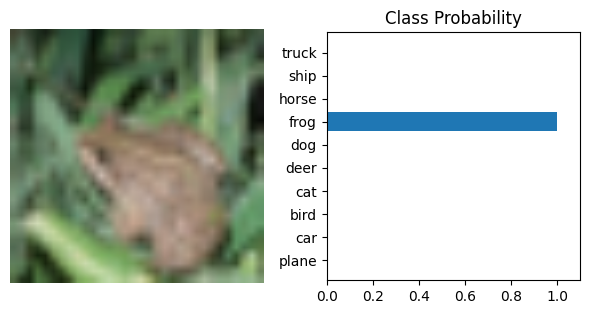

In [19]:
# Load best model for inference
net.load_state_dict(torch.load('best_model.pth'))
net.eval()

images, _ = next(iter(test_loader))

image = images[4]
batched_image = image.unsqueeze(0).to(device)
with torch.no_grad():
    log_probabilities = net(batched_image)

probabilities = torch.exp(log_probabilities).squeeze().cpu()
view_classification(image.cpu(), probabilities)

In [14]:
# Final evaluation on test set
net.eval()
correct = 0
total = 0
class_correct = [0] * 10
class_total = [0] * 10

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Per-class accuracy
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print(f'Overall Accuracy: {100 * correct / total:.2f}%')
print('\nPer-class Accuracy:')
for i in range(10):
    accuracy = 100 * class_correct[i] / class_total[i]
    print(f'{classes[i]:10s}: {accuracy:.2f}%')

Overall Accuracy: 90.09%

Per-class Accuracy:
plane     : 90.10%
car       : 94.10%
bird      : 85.80%
cat       : 82.30%
deer      : 92.40%
dog       : 76.10%
frog      : 95.80%
horse     : 94.00%
ship      : 96.60%
truck     : 93.70%
